In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import silkscreen
import numpy as np
import torch
import artpop
import matplotlib.pyplot as plt
import mpire
import tqdm

In [3]:
x = torch.ones( (500,3,50,50) )

In [5]:
x[200:].shape

torch.Size([300, 3, 50, 50])

In [3]:
# Build observation class
psf = artpop.psf.moffat_psf(0.7)
iso_kwargs = dict(mag_limit=26, mag_limit_band='hsc_g')

obs = silkscreen.SilkScreenObservation(data = np.ones((2,151,151)), imager = 'HSC', filters = ['hsc_g','hsc_r'],
exp_time = 1000, pixel_scale = 0.262, zpt = 25, psf = psf, distribution= 'plummer', distribution_kwargs={'scale_radius_as': 10}, iso_kwargs=iso_kwargs)
prior = silkscreen.priors.get_SSP_prior([4.,6.],[3.,4.],[-1.,-0.6],[5.,10.])

In [4]:
#Initiate Simmer class, can take ~20s
sim_test = silkscreen.SSPSimmer(obs)

In [5]:
def run_sims(sim_func, proposal, num, samp_kwargs = {}) -> torch.Tensor:
    theta = proposal.sample((num,), **samp_kwargs)# Always need on cpu
    x = []
    for theta_cur in tqdm.tqdm(theta):
        x.append(sim_func(theta_cur))
    x = torch.stack(x)
    return theta,x

In [41]:
def run_sims_mpire(sim_func, proposal, num, n_jobs = 4, samp_kwargs = {}) -> torch.Tensor:
    theta = proposal.sample((num,), **samp_kwargs).to('cpu')# Always need on cpu
    to_mpire = lambda *x: sim_func(torch.stack(x))
    with mpire.WorkerPool(n_jobs=n_jobs) as pool:
        x = pool.map(to_mpire, theta, progress_bar = True)
    x = torch.stack(x)
    return theta,x

In [1]:
r = 5_000
max_append = 10_000
num_r_append = int(r/max_append)

if num_r_append == 0:
    print ('0')
else:
    for r_append in range(num_r_append):
        print (r_append*max_append, (r_append+1)*max_append)
    if r%max_append != 0:
        print ( (r_append+1)*max_append )

0


In [54]:
int( r / max_append )

0

In [45]:
run_sims(partial(sim_test.get_image, output = 'torch'), prior, 50)

100%|██████████| 50/50 [00:02<00:00, 18.84it/s]


(array([[ 5.10386086,  3.46368861, -0.90609574,  5.36147213],
        [ 4.66891241,  3.49714947, -0.83998573,  6.66175652],
        [ 4.11349297,  3.32583451, -0.78952539,  9.3878212 ],
        [ 4.64927673,  3.69624519, -0.83660507,  9.25022411],
        [ 4.58917999,  3.54203248, -0.90172875,  8.21083546],
        [ 4.55861759,  3.7029438 , -0.84330297,  9.73834991],
        [ 4.7700119 ,  3.88045835, -0.98740906,  7.9764986 ],
        [ 5.82642651,  3.98928118, -0.68697178,  8.1631279 ],
        [ 4.1368475 ,  3.81877613, -0.85135019,  8.38022804],
        [ 5.95139122,  3.75671887, -0.90511757,  6.1119175 ],
        [ 4.8966403 ,  3.26250672, -0.86656165,  9.55821609],
        [ 5.02412033,  3.14842772, -0.85111606,  6.03100014],
        [ 5.95892811,  3.71916318, -0.62486601,  9.96810722],
        [ 5.62547493,  3.50508738, -0.93094319,  6.79924345],
        [ 4.96610022,  3.290802  , -0.93329942,  5.78201294],
        [ 4.55688477,  3.76187706, -0.70699066,  9.62108707],
        

In [44]:
run_sims_mpire(sim_test.get_image, prior, 500, n_jobs=1)

100%|██████████| 500/500 [00:25<00:00, 22.10it/s]


TypeError: stack(): argument 'tensors' (position 1) must be tuple of Tensors, not numpy.ndarray

In [17]:
sim_test.iso_list[0].isocmds[0].shape

(238,)

In [7]:
%%timeit 
iso = sim_test.build_ssp(4,0.11,-1,9)

1.66 s ± 179 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


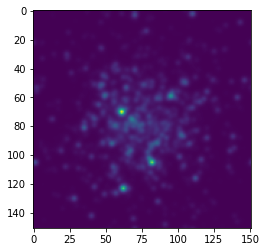

In [6]:
plt.imshow(sim_im[0])